# (연구&서연) GODE – Ex2 Distance Histogram 시각화

최규빈  
2024-08-14

ref:
https://seoyeonc.github.io/GODE_blog/posts/Result/3_table/2024-06-22-final_GODE_code_JKSS_review.html

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random
import pickle

import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
from haversine import haversine
from IPython.display import HTML
import plotly.graph_objects as go
import copy 

import tqdm
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector 

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc

In [12]:
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
from pyod.models.ocsvm import OCSVM
from pyod.models.mcd import MCD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.sos import SOS
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.lscp import LSCP

In [13]:
plt.rcParams['text.usetex'] = True

In [14]:
class Conf_matrx:
    def __init__(self,original,compare):
        self.original = original
        self.compare = compare
    def conf(self,name):
        self.name = name
        self.conf_matrix = confusion_matrix(self.original, self.compare)
        
        # fig, ax = plt.subplots(figsize=(5, 5))
        # ax.matshow(self.conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
        # for i in range(self.conf_matrix.shape[0]):
        #     for j in range(self.conf_matrix.shape[1]):
        #         ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')
        # plt.xlabel('Predictions', fontsize=18)
        # plt.ylabel('Actuals', fontsize=18)
        # plt.title('Confusion Matrix of ' + str(name), fontsize=18)
        # plt.show()
        
        self.acc = accuracy_score(self.original, self.compare)
        self.pre = precision_score(self.original, self.compare)
        self.rec = recall_score(self.original, self.compare)
        self.f1 = f1_score(self.original, self.compare)
        
        # print('Accuracy: %.3f' % self.acc)
        # print('Precision: %.3f' % self.pre)
        # print('Recall: %.3f' % self.rec)
        # print('F1 Score: %.3f' % self.f1)

In [15]:
class Orbit:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.power),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)

In [16]:
class fortable:
    def __init__(self, df, clf, tab, outlier_true, conf_name = "Method"):
        self.df = df
        self.clf = clf
        self.conf_name = conf_name
        self.tabb = tab
        self.outlier_true = outlier_true
        
    def _forfit(self):
        if 'fnoise' in self.df.columns:
            self.clf.fit(self.df[['x', 'y','fnoise']])
        elif 'f' in self.df.columns:
            self.clf.fit(self.df[['x', 'y', 'f']])
        if 'f' not in self.df.columns:
            self.clf.fit(self.df[['x', 'y']])

    def _forlabels(self):
        self.labels = list(self.clf.labels_)

    def _forpredict(self):
        self.predict = self.clf.fit_predict(self.df)
        
    def comparison(self, compare_outlier = None, conf_outlier = None, gode = False):
        if gode == False:
            self._forfit()
            self._forlabels()
            if 'fnoise' in self.df.columns:
                compare_outlier = self.clf.decision_function(np.array(self.df[['x', 'y','fnoise']]))
            else:
                compare_outlier = self.clf.decision_function(self.df)
            if self.conf_name == "LOF":
                self._forpredict()
                conf_outlier = self.predict
            elif self.conf_name != "LOF":
                conf_outlier = self.labels
        elif gode == True:
            compare_outlier = compare_outlier
            conf_outlier = conf_outlier

        fpr, tpr, thresh = roc_curve(self.outlier_true, compare_outlier)       
        
        _conf = Conf_matrx(self.outlier_true, conf_outlier)
        _conf.conf(self.conf_name)
        
        _table = pd.concat([self.tabb,
                   pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)],"N":n, "Contamination": eta_sparsity,"kappa":kappa},index = [_conf.name])])
        
        return _table

# Orbit

In [21]:
n = 1000
eta_sparsity = 0.05
random_seed=77
np.random.seed(777)
epsilon = np.around(np.random.normal(size=n),15)
signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
eta = signal + epsilon
pi=np.pi
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + eta
data = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})
outlier_true_orbit = signal.copy()
outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))

# GODE

In [23]:
orbit = Orbit(data)
orbit.get_distance()
dists = np.array([orbit.D[i,j] for i in range(len(orbit.f)) for j in range(i+1,len(orbit.f))])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 733.77it/s]

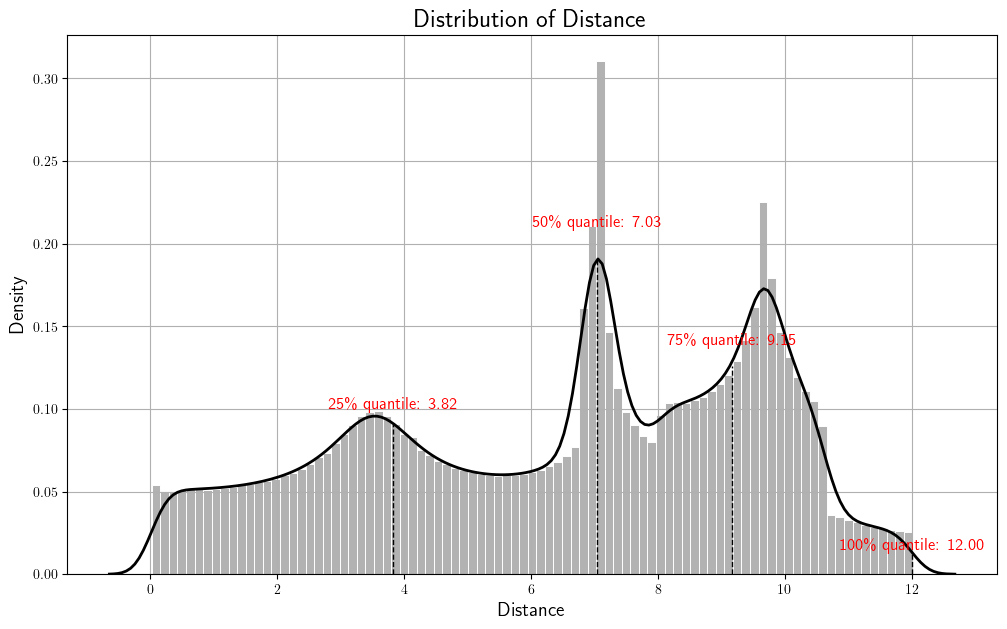

25% quantile: 3.82
50% quantile: 7.03
75% quantile: 9.15
100% quantile: 12.00

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the quantiles (25%, 50%, 75%, 100%)
quantiles = np.percentile(dists, [25, 50, 75, 100])

# Calculate the optimal number of bins using the Freedman-Diaconis rule
q75, q25 = np.percentile(dists, [75, 25])
iqr = q75 - q25
bin_width = 2 * iqr * len(dists) ** (-1/3)
bins = int((dists.max() - dists.min()) / bin_width)

# Set up the figure
plt.figure(figsize=(12, 7))

# Plot the histogram with the calculated bin size and gray bins
sns.histplot(dists, bins=bins, kde=False, stat="density", color='gray', edgecolor='white', alpha=0.6)

# Overlay the KDE plot with a black line
kde = sns.kdeplot(dists, color='black', linewidth=2)

# Get the density values from the KDE plot for each quantile
density_values = kde.get_lines()[0].get_data()

# Add vertical lines at each quantile with black color and adjust the height
for i, q in enumerate(quantiles):
    # Find the closest x value in the KDE data and corresponding y value (density)
    idx = np.argmin(np.abs(density_values[0] - q))
    plt.axvline(q, color='black', linestyle='--', linewidth=1, ymax=density_values[1][idx] / plt.ylim()[1])
    # Annotate the quantile with detailed text on the x-axis
    plt.text(q, density_values[1][idx] * 1.1, f'{25 * (i + 1)}\% quantile: {q:.2f}', color='red', fontsize=12, ha='center')

# Add titles and labels
plt.title('Distribution of Distance', fontsize=18, fontweight='bold')
plt.xlabel('Distance', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(True)

# Show the plot
plt.show()

# Print the quantile values (for reference)
for i, q in enumerate(quantiles):
    print(f'{25 * (i + 1)}% quantile: {q:.2f}')
